<a href="https://colab.research.google.com/github/FredyOrjuela90/Be-star-Bayesian-Inference-Analysis/blob/main/Results/LenorzerCorner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
import os
import glob as glob
from scipy.interpolate import griddata, RegularGridInterpolator
from scipy.ndimage import gaussian_filter
from scipy.special import erf
from scipy.stats import gaussian_kde
from typing import Tuple
from scipy.stats import spearmanr
from matplotlib.colors import Colormap
from matplotlib import colormaps
from matplotlib.patches import Circle
import re

In [ ]:
column_names = [
    '$n$',
    '$\log(\\Sigma\,[\mathrm{g\,cm^{-2}}])$',
    '$M\,[M_\odot]$',
    '$1+0.5W^2$',
    '$\cos i$',
    '$\log\left(\\frac{F(\\mathrm{Hu}14)}{F(\\mathrm{Pf}\gamma)}\\right)$',
    '$\log\left(\\frac{F(\\mathrm{Hu}14)}{F(\\mathrm{Br}\\alpha)}\\right)$',
    '$\\frac{F(\\mathrm{Hu}14)}{F(\lambda_B^*)}\,[\\mathrm{A}]$',
    '$v\sin i\,[\\mathrm{km/s}]$'
]

data = pd.read_csv('/content/drive/MyDrive/Be-HDUST/CornersPaper/samples_lenorzer.out', sep=' ', names=column_names)
print(data.shape)


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\,'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\,'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2213276910.py:3: SyntaxWarning: invalid escape sequence '\l'
  '$\log(\\Sigma\,[\mathrm{g\,cm^{-2}}])$',
/tmp/ipython-input-2213276910.py:4: SyntaxWarning: invalid escape sequence '\,'
  '$M\,[M_\odot]$',
/tmp/ipython-input-2213276910.py:6: SyntaxWarning: invalid escape sequence

(100000, 9)


In [ ]:
# Separar la octava y la novena columna
columna_uno_min = np.min(data.iloc[:,0])
columna_uno_max = np.max(data.iloc[:,0])
print(columna_uno_min,columna_uno_max)
nine_column = data.iloc[:, 8]
# Eliminar la novena columna para el corner plot
#data_first = data.drop([data.columns[7], data.columns[8]], axis=1).values
data_first = data.drop(data.columns[8], axis=1).values
print(data_first)

2.0004301316869095 4.499882566561929
[[ 2.95303364  0.04608516  5.03860083 ... -1.28317605 -0.80316095
   1.89171465]
 [ 3.7994951   0.50237826  6.60425083 ... -0.36519514 -1.06134641
   1.31539578]
 [ 4.06181093  0.27727521 11.60072366 ... -0.60926468 -0.67560448
   0.30951289]
 ...
 [ 4.04029795 -0.44552817  9.5523549  ... -0.92922342 -1.08793352
   0.48426773]
 [ 2.83516    -0.22571791  9.7999956  ... -1.55797078 -1.7562506
   0.57066651]
 [ 3.13512832  0.28739372 11.75398745 ... -0.99847329 -1.12481018
   1.52084259]]


In [ ]:

def cornerplot(
    data: np.ndarray,
    cmap="Blues",
    correlation_textcolor=None,
    dpi=100.,
    hex_gridsize=30,
    highlight=None,
    highlight_linecolor=None,
    highlight_markercolor=None,
    hist_backgroundcolor=None,
    hist_bins=20,
    hist_edgecolor=None,
    hist_facecolor=None,
    labels=None,
    limits=None,
    scatter_alpha=0.5,
    scatter_markercolor=None,
    scatter_outside_sigma=None,
    show_correlations=False,
    show_scorrelations=False,
    sigma_levels=None,
    sigma_linecolor=None,
    sigma_smooth=3.,
    title_quantiles=None,
    width=3.
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """
    Function creates hexbin corner plot matrix to visualize multidimensional data.

    Parameters:
    -----------
    data : (N_sample, N_dims) array-like
        Two-dimensional data array to be visualized. First dimension are the samples,
        second dimension the features.
    cmap : str or matplotlib.colors.Colormap, optional, default: "Blues"
        Either a string of a valid matplotlib colormap or a custom Colormap object
        to be used in the plot.
    correlation_textcolor : str, optional, default: None
        Color of correlation text.
        Defaults to a value from the chosen colormap.
    dpi : float, optional, default: 100.
        Dots per inch of the figure
    hex_gridsize : int, optional, default: 30
        Number of hexagons ins x-direction
    highlight : (N_dims) array-like, optional, default: None
        If not None, array of values to be highlighted in the plot. Typically
        the truth values.
    highlight_linecolor : str or tuple, optional, default: None
        If not None linecolor of the highlighted values.
        Defaults to a value from the chosen colormap.
    highlight_markercolor : str or tuple, optional, default: None
        If not None markercolor of the highlighted values.
        Defaults to a value from the chosen colormap.
    hist_backgroundcolor : str or tuple, optional, default: None
        If not None background color of the axes object.
        Defaults to a value from the chosen colormap.
    hist_bins : int, optinal, default: 20
        Number of bins in histograms.
    hist_edgecolor : str or tuple, optional, default: None
        If not None edgecolor of the histgram bars.
        Defaults to a value from the chosen colormap.
    hist_facecolor : str or tuple, optional, default: None
        If not None face of the histgram bars.
        Defaults to a value from the chosen colormap.
    labels : (N_dims) list, optional, default: None
        If not None list of strings with the feature names
        to be used as axis labels or in the axis titles.
    limits : (2,) or (N_dims, 2) array-like, optional, default: None
        If not None limits is the axis limits of the
        features giving the minimum and maximum values
        of each feature
    scatter_alpha : float, optional, default: 0.5
        Alpha transparency value of scatter plot
    scatter_markercolor : str, optional, default: None
        If not None markercolor of scatter plot markers.
        Defaults to a value from the chosen colormap.
    scatter_outside_sigma : float, optional, default: None
        If not None displays scatter plot of individual data
        points outside of given sigma contour.
    show_correlations : boolean, optional, default: False
        If True show Pearson's correlation coeffiction in each tile.
    sigma_levels : array_like, optional, default: None
        If not None contour levels to be plotted in
        units of the standard deviation.
    sigma_linecolor : str or tuple, optional, default: None
        If not None linecolor of the sigma contour lines.
        Defaults to a value from the chosen colormap.
    sigma_smooth : float, optional, default: 3.
        Smoothing factor for hexbin plot to smooth
        out contour lines.
    title_quantiles : (1,) or (3,) array-like, optional, default: None
        One-dimensional array of either size one or size three with
        the feature quantiles to be plotted as histogram titles.
    width : float, optional, default: 3.
        Width of a single tile of the corner plot.

    Returns:
    --------
    (fig, ax) : tuple
        Tuple containing the figure and axes objects.
    """

    # Number of dimensions
    _, Nd = data.shape

    # Validate colormap
    if isinstance(cmap, str):
        cm = colormaps[cmap]
    elif isinstance(cmap, Colormap):
        cm = cmap
    else:
        raise ValueError(
            "'cmap' has to be either type str or LinearSegmentedColormap.")

    # Setting colors
    hl_lc = highlight_linecolor if highlight_linecolor is not None else cm(1.)
    hl_mc = highlight_markercolor if highlight_markercolor is not None \
        else cm(0.)
    sig_lc = sigma_linecolor if sigma_linecolor is not None else cm(1.)
    hist_bc = hist_backgroundcolor if hist_backgroundcolor is not None \
        else cm(0.)
    hist_ec = hist_edgecolor if hist_edgecolor is not None else cm(1.)
    hist_fc = hist_facecolor if hist_facecolor is not None else cm(0.5)
    scat_mc = scatter_markercolor if scatter_markercolor is not None else cm(
        0.5)

    # Validate labels
    set_labels = False if labels is None else True
    if set_labels:
        if len(labels) != Nd:
            raise ValueError(
                "Size of 'labels' does not match number of dimensions.")

    # Validate highlights
    set_highlights = False if highlight is None else True
    if set_highlights:
        if len(highlight) != Nd:
            raise ValueError(
                "Size of 'highlight' does not match number of dimensions.")

    # Produce levels
    if sigma_levels is not None:
        # Converting to 1d quantiles
        quants = []
        for s in sigma_levels:
            q = sigma_to_quantile(s)
            quants.extend([50.-q, 50.+q])
        quants = np.array(quants)
        quants.sort()
        # Converting to 2d sigma levels
        levels2d = 1. - np.exp(-0.5*np.array(sigma_levels)**2)

    # Threshold for scatter plot
    if scatter_outside_sigma is not None:
        scatter_thr = 1. - np.exp(-0.5*np.array(scatter_outside_sigma)**2)

    # Validate title quantiles
    if title_quantiles is not None:
        if len(title_quantiles) not in [1, 3]:
            raise ValueError(
                "'title_quantiles' has to have either size 1 or size 3.")
        title_quantiles = np.array(title_quantiles)
        title_quantiles.sort()

    # Compute correlation coefficients
    if show_correlations:
        rho = np.corrcoef(data.T)
        cor_tc = correlation_textcolor if correlation_textcolor is not None else cm(
            1.)
    # Calcular coeficientes de correlación de Spearman
    if show_scorrelations:
        rhos, _ = spearmanr(data, axis=0)  # Correlación entre columnas (variables)
        cor_tc = correlation_textcolor if correlation_textcolor is not None else cm(1.)


    # Setting limits
    lim = np.empty((Nd, 2))
    if limits is not None:
        l = np.array(limits)
        if l.shape not in [(2,), (Nd, 2)]:
            raise ValueError("'limits' does not have the correct shape.")
        lim[...] = l[None, :] if len(l.shape) == 1 else l
    else:
        lim[:, 0] = data.min(axis=0)
        lim[:, 1] = data.max(axis=0)

    fig, ax = plt.subplots(nrows=Nd, ncols=Nd, figsize=(
        Nd*width, Nd*width), dpi=dpi,constrained_layout=True)

    for i in range(Nd**2):
        # x and y coordinates of subplots
        ix, iy = np.divmod(i, Nd)

        if iy > ix:
            # Remove axes outside of corner plot
            fig.delaxes(ax[ix, iy])
        elif ix == iy:
            # Histograms
            ax[ix, iy].set_facecolor(hist_bc)
            ax[ix, iy].hist(data[:, ix], bins=hist_bins, color=cm(1.),
                            facecolor=hist_fc, edgecolor=hist_ec)
            if sigma_levels is not None:
                perc = np.percentile(data[:, ix], quants)
                for p in perc:
                    ax[ix, iy].axvline(p, ls="--", lw=1, c=sig_lc)
            if set_highlights:
                ax[ix, iy].axvline(highlight[iy], ls="-", color=hl_lc)
            if title_quantiles is not None:
                perc = np.percentile(data[:, ix], title_quantiles)
                if len(title_quantiles) == 1:
                    if labels is not None:
                        prefix = "{} $= ".format(labels[iy])
                    else:
                        prefix = "$"
                    msg = "{}{{{:.2f}}}$".format(
                        prefix, perc[0])
                else:
                    diff = np.diff(perc)
                    if labels is not None:
                        prefix = "{} $= ".format(labels[iy])
                    else:
                        prefix = "$"
                    msg = "{}{{{:.2f}}}^{{+{:.2f}}}_{{-{:.2f}}}$".format(
                        prefix, perc[1], diff[1], diff[0])
                #ax[ix, iy].set_title(msg, fontsize="x-large")
                ax[ix, iy].set_title(msg, fontsize=16)
        else:
            # Hexbin plots
            h = ax[ix, iy].hexbin(
                data[:, iy], data[:, ix],
                cmap=cm,
                gridsize=hex_gridsize,
                linewidths=0.5,
                edgecolor=cm(0),
                extent=(lim[iy, 0], lim[iy, 1], lim[ix, 0], lim[ix, 1])
            )

            # Data gridding if sigma_levels given or scatter plot required
            if sigma_levels is not None or scatter_outside_sigma is not None:

                # Get positions and values from hexbin plots
                xy = h.get_offsets()
                z = h.get_array()

                # Compute gridded data for contour plot
                grid_x, grid_y = np.mgrid[
                    xy[:, 0].min():xy[:, 0].max():3*hex_gridsize*1j,
                    xy[:, 1].min():xy[:, 1].max():3*hex_gridsize*1j
                ]
                zi = griddata(xy, z, (grid_x, grid_y), method="linear")
                # Smooth data to forget about hexplot grid
                zi = gaussian_filter(zi, sigma_smooth)

                # Convert sigma levels to data levels
                z_flattened = zi.flatten()
                z_ordered = z_flattened[z_flattened.argsort()[::-1]]
                cumsum = z_ordered.cumsum()
                cumsum /= cumsum[-1]

            # Contourplot
            if sigma_levels is not None:
                # Compute levels
                levels = np.empty(len(levels2d))
                for i, s in enumerate(levels2d):
                    levels[i] = z_ordered[np.abs(cumsum-s).argmin()]
                levels.sort()
                # Draw plot
                ax[ix, iy].contour(
                    grid_x, grid_y, zi,
                    levels=levels,
                    colors=[sig_lc],
                    linewidths=1.,
                    linestyles="--"
                )

            # Scatter plot
            if scatter_outside_sigma is not None:
                # Compute threshold value
                scat_thr = z_ordered[np.abs(cumsum-scatter_thr).argmin()]
                # Nearest neighbor search
                NNDI = RegularGridInterpolator(
                    (grid_x[:, 0], grid_y[0, :]),
                    zi,
                    method="linear",
                    bounds_error=False,
                    fill_value=0.
                )
                mask = NNDI((data[:, iy], data[:, ix])) < scat_thr
                ax[ix, iy].scatter(
                    data[mask, iy], data[mask, ix],
                    marker=".",
                    s=0.5,
                    alpha=scatter_alpha,
                    c=[scat_mc])



            # Correlation coefficient Pearson
            if show_correlations:
                msg = r"$\rho = {{{:.2f}}}$".format(rho[ix, iy])
                # Visualización de los coeficientes de correlación

                msg = "     " +r"$\rho_s = {{{:.2f}}}$".format(rhos[ix, iy])

                # Acceder al eje correcto en la matriz de subtramas
                axis = ax[ix, iy]

                # Crear un normalizador para mapear los valores de correlación al rango [0, 1]
                norm = plt.Normalize(vmin=-1, vmax=1)
                # Mapear el valor de correlación a un color en el colormap
                coloress = plt.cm.plasma(rhos[ix, iy])
                # Agregar un círculo de color
                # Coordenadas para el círculo y el texto
                circle_xy = (0.08, 0.92)
                text_xy = (0.04, 0.95)


            # Calcular coeficientes de correlación de Spearman
            if show_scorrelations:
                rhos, _ = spearmanr(data, axis=0)  # Correlación entre columnas (variables)
                cor_tc = correlation_textcolor if correlation_textcolor is not None else cmap(1.)

                # Visualización de los coeficientes de correlación

                msg = "     " +r"$\rho_s = {{{:.2f}}}$".format(rhos[ix, iy])

                # Acceder al eje correcto en la matriz de subtramas
                axis = ax[ix, iy]

                # Crear un normalizador para mapear los valores de correlación al rango [0, 1]
                norm = plt.Normalize(vmin=-1, vmax=1)
                # Mapear el valor de correlación a un color en el colormap
                coloress = plt.cm.plasma(norm(rhos[ix, iy]))
                # Agregar un círculo de color
                # Coordenadas para el círculo y el texto
                circle_xy = (0.08, 0.90)
                text_xy = (0.04, 0.95)




                # Agregar el texto con un rectángulo
                bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor=coloress, alpha=0.5)
                axis.text(
                    text_xy[0], text_xy[1], msg,
                    va="top", ha="left",
                    transform=axis.transAxes,
                    c=cor_tc,
                    fontsize=16,
                    fontweight='bold',
                    bbox=bbox_props
                )
                # Agregar un círculo de color
                circle = Circle(circle_xy, 0.05, transform=axis.transAxes, color=coloress, alpha=1.0)
                axis.add_patch(circle)


            # Set the highlights
            if set_highlights:
                ax[ix, iy].axvline(highlight[iy], ls="-", color=hl_lc)
                ax[ix, iy].axhline(highlight[ix], ls="-", color=hl_lc)
                ax[ix, iy].plot(
                    highlight[iy], highlight[ix],
                    marker=(6, 0, 0),
                    markersize=8,
                    c=hl_mc,
                    markeredgecolor=hl_lc
                )

        # Setting limits
        if ix == Nd-1:
            #ax[ix, iy].set_xlim(data[:, iy].min(), data[:, iy].max())
            #ax[ix, iy].set_ylim(data[:, ix].min(), data[:, ix].max())
            ax[ix, iy].set_xlim(lim[iy, 0], lim[iy, 1])
        if ix > 0 and iy == 0:
            ax[ix, iy].set_ylim(lim[ix, 0], lim[ix, 1])

        # Set y-labels
        if ix > 0 and iy == 0:
            if set_labels:
                #ax[ix, iy].set_ylabel(labels[ix], fontsize="x-large")
                ax[ix, iy].set_ylabel(labels[ix], fontsize=22)
        elif iy < ix:
            ax[ix, iy].sharey(ax[ix, 0])
            plt.setp(ax[ix, iy].get_yticklabels(), visible=False)
        else:
            plt.setp(ax[ix, iy].get_yticklabels(), visible=False)

        # Set x-labels
        if ix == Nd-1:
            if set_labels:
                #ax[ix, iy].set_xlabel(labels[iy], fontsize="x-large")
                ax[ix, iy].set_xlabel(labels[iy], fontsize=22)
        else:
            ax[ix, iy].sharex(ax[Nd-1, iy])
            plt.setp(ax[ix, iy].get_xticklabels(), visible=False)



    # Agregar colorbar con colormap plasma en la ubicación específica
    # Crear ScalarMappable con los límites -1 y 1
    sm = matplotlib.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=-1, vmax=1))

    # Agregar colorbar con colormap plasma en la ubicación específica
    # Definir una nueva ubicación para la barra de color
    cbar_ax = fig.add_axes([0.27, 0.96, 0.36, 0.019])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Spearman Correlation',fontsize=18)

    # Crear un eje en la ubicación específica para el gráfico de dispersión
    ax_scatter = fig.add_axes([0.49, 0.65, 0.505, 0.25])  # [left, bottom, width, height]



    # Diccionario data2

    data2 = {
        "Object": ["o Cas", "γ Cas", "V777 Cas", "Bk Cam", "17 Tau", "23 Tau","25 Tau", "28 Tau", "12 Vul", "28 Cyg", "V2113 Cyg", "V2119 Cyg",
                "V2120 Cyg", "β Psc", "25 Peg", "16 Peg", "V2162 Cyg", "υ Cyg","60 Cyg", "V568 Cyg", "V2123 Cyg"],
        "Group": ["II", "I", "II", "I", "I", "I","II", "I", "I", "III", "II", "II", "I", "III", "III", "I", "II", "III",
                  "II", "I", "I"],
        "n": [3.75, 3.61, 3.94, 3.86, 3.71, 3.57,
              3.16, 3.74, 3.78, 3.78, 3.78, 4.23,
              3.86, 3.58, 3.53, 3.78, 3.78, 3.77,
              3.82, 4.25, 3.56],
        "n_err_low": [0.21, 0.08, 0.06, 0.07, 0.38, 0.13,
                      0.09, 0.29, 0.44, 0.05, 0.08, 0.09,
                      0.09, 0.14, 0.12, 0.43, 0.07, 0.08,
                      0.07, 0.07, 0.11],
        "n_err_high": [0.35, 0.53, 0.14, 0.37, 0.76, 0.72,
                      0.70, 0.56, 0.67, 0.22, 0.45, 0.23,
                      0.34, 0.45, 0.39, 0.67, 0.40, 0.46,
                      0.37, 0.21, 0.43],
        "logΣ": [-0.80, 0.10, -0.68, 0.30, -0.51, 0.07,
                -1.17, -0.84, -0.53, 0.30, 0.27, 0.04,
                -1.06, -0.28, -0.03, -0.56, 0.31, 0.18,
                0.28, -0.07, 0.02],
        "logΣ_err_low": [0.16, 0.25, 0.33, 0.28, 0.63, 0.25,
                        0.14, 0.23, 0.61, 0.24, 0.31, 0.15,
                        0.13, 0.27, 0.23, 0.65, 0.27, 0.28,
                        0.27, 0.11, 0.25],
        "logΣ_err_high": [1.27, 0.48, 0.87, 0.29, 1.06, 0.50,
                          0.59, 1.27, 1.09, 0.29, 0.33, 0.50,
                          0.95, 0.82, 0.60, 1.09, 0.28, 0.40,
                          0.31, 0.49, 0.55]
    }

    # Crear un DataFrame
    df2 = pd.DataFrame(data2)




    # Inicializar variables para controlar la adición de las etiquetas del grupo
    label_group_i_added = False
    label_group_ii_added = False
    label_group_iii_added = False

    # Agregar barras de error con colores específicos
    for i, row in df2.iterrows():
        if row['Group'] == 'I':
            color = 'cyan'
            if not label_group_i_added:
                ax_scatter.errorbar(x=row['n'], y=row['logΣ'],
                            xerr=[[row['n_err_low']], [row['n_err_high']]],
                            yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                            fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8, label='Group I (≳ 0.5)')
                label_group_i_added = True
            else:
                ax_scatter.errorbar(x=row['n'], y=row['logΣ'],
                            xerr=[[row['n_err_low']], [row['n_err_high']]],
                            yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                            fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8)
        elif row['Group'] == 'II':
            color = 'lime'
            if not label_group_ii_added:
                ax_scatter.errorbar(x=row['n'], y=row['logΣ'],
                            xerr=[[row['n_err_low']], [row['n_err_high']]],
                            yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                            fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8, label='Group II (≲ 0.5)')
                label_group_ii_added = True
            else:
                ax_scatter.errorbar(x=row['n'], y=row['logΣ'],
                            xerr=[[row['n_err_low']], [row['n_err_high']]],
                            yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                            fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8)
        elif row['Group'] == 'III':
            color = 'magenta'
            if not label_group_iii_added:
                ax_scatter.errorbar(x=row['n'], y=row['logΣ'],
                            xerr=[[row['n_err_low']], [row['n_err_high']]],
                            yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                            fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8, label='Group III')
                label_group_iii_added = True
            else:
                ax_scatter.errorbar(x=row['n'], y=row['logΣ'],
                            xerr=[[row['n_err_low']], [row['n_err_high']]],
                            yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                            fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8)

    # Añadir etiquetas para cada punto
    for i, row in df2.iterrows():
        ax_scatter.text(row['n'], row['logΣ'], row['Object'], fontsize=7, ha='right')

    # Cargar los datos
    lenorzer_data = pd.read_csv('/content/drive/MyDrive/Be-HDUST/CornersPaper/samples_lenorzer.out', sep=' ', names=column_names)


    # Definir las variables X y Y a partir de las columnas del DataFrame
    X_d = lenorzer_data.iloc[:, 0]
    y_d = lenorzer_data.iloc[:, 1]


    # Crear un grid para los contornos
    x_grid = np.linspace(X_d.min(), X_d.max(), 50)
    y_grid = np.linspace(y_d.min(), y_d.max(), 50)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

    # Calcular la densidad con una función de densidad de kernel (KDE)
    kde = gaussian_kde(np.vstack([X_d, y_d]))
    Z = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)

    # Dibujar las superficies de nivel
    contour = ax_scatter.contourf(X_grid, Y_grid, Z, levels=50, cmap="Purples")

    # Crear el diagrama de dispersión con Seaborn
    sns.scatterplot(x='n', y='logΣ', data=df2, s=400, marker='*', color='gold', ax=ax_scatter)
    ax_scatter.scatter(X_d, y_d, color='violet', marker='o', s=0.05, alpha=0.2)  # Puntos de dispersión

    # Agregar una barra de color
    cbar = plt.colorbar(contour, ax=ax_scatter)


    # Etiquetas de los ejes
    ax_scatter.set_xlabel(r'$n$', fontsize=22)
    ax_scatter.set_ylabel(r'$\log(\Sigma \, [g \, cm^{-2}])$', fontsize=22)

    # Etiquetas y título con formato LaTeX
    ax_scatter.set_xlim(np.min(lenorzer_data.iloc[:, 0]) - 0.15, np.max(lenorzer_data.iloc[:, 0]) + 0.15)
    ax_scatter.set_ylim(np.min(lenorzer_data.iloc[:, 1]) - 0.3, np.max(lenorzer_data.iloc[:, 1]) + 0.3)


    # Activar marcas menores
    ax_scatter.minorticks_on()
    ax_scatter.grid(which='both', linestyle=':', linewidth=0.2)
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True)

    # Mostrar la leyenda
    ax_scatter.legend(loc='lower left',fontsize=16)

    plt.savefig('/content/drive/MyDrive/Be-HDUST/CornersPaper/Lenorzer_corner.png', dpi=720)

    #fig.tight_layout()

    plt.show()

    return fig, ax


def sigma_to_quantile(sig: float) -> float:
    """
    Function converts standard deviation of
    a normal distribution to quantile.

    Parameters:
    -----------
    sig : float
        Standard deviation

    Returns:
    --------
    q : float
        Quantile
    """
    return _gaussian_primitive(-sig, 0., 1.)*100


def _gaussian_primitive(x: float, mu: float, sig: float) -> float:
    """
    Function returns the primitive of the normal distribution

    Parameters:
    -----------
    x : float, array-like
        Evaluation coordinate
    mu : float
        Mean of normal distribution
    sig : float
        Standard deviation of normal distribution

    Returns:
    --------
    F(x) : float, array-like
        Primitive at x
    """

    return -0.5*erf((x-mu)/(np.sqrt(2.)*sig))

[ 3.3804      0.14052587  9.21589753  1.33550142  0.58992475 -0.79370189
 -0.9390967   2.23060173]
[ 3.37248909  0.2743959   8.48115474  1.34144484  0.62322354 -0.79480713
 -0.94662115  1.85542167]
[np.float64(15.86552539314571), 50, np.float64(84.1344746068543)]


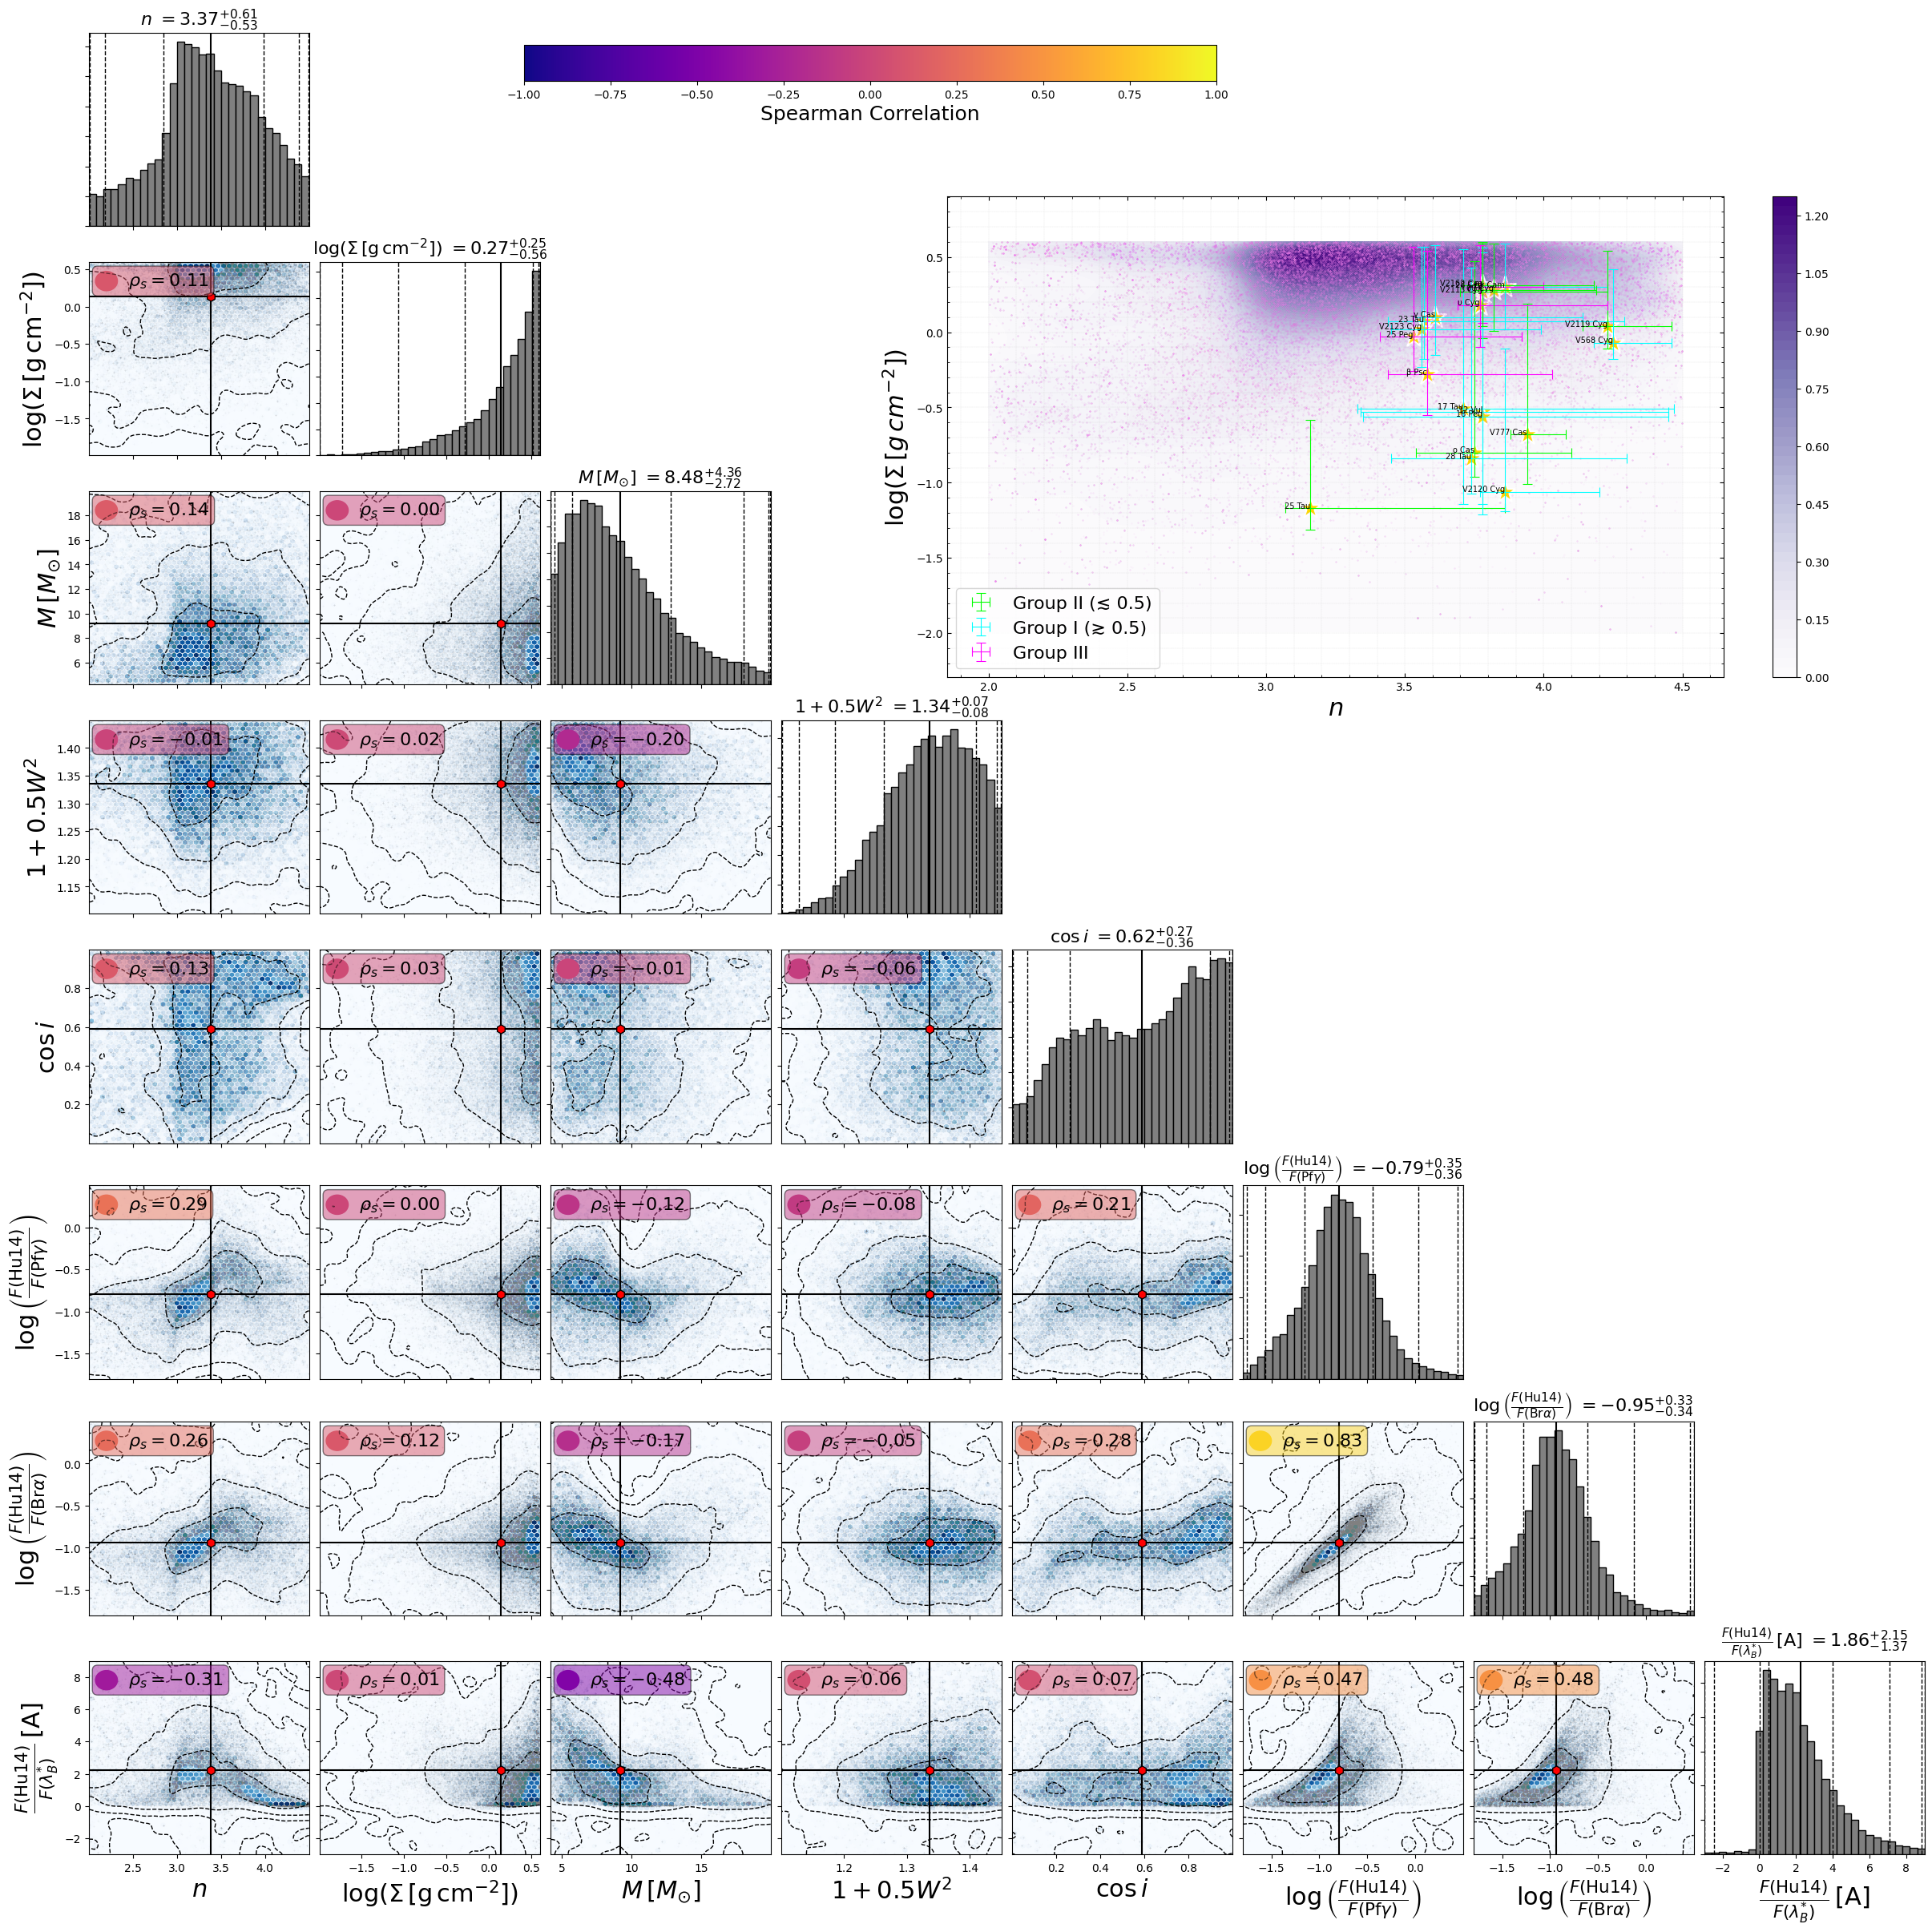

(<Figure size 2400x2400 with 39 Axes>,
 array([[<Axes: title={'center': '$n$ $= {3.37}^{+0.61}_{-0.53}$'}>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='$\\log(\\Sigma \\,[\\mathrm{g \\, cm^{-2}}])$'>,
         <Axes: title={'center': '$\\log(\\Sigma \\,[\\mathrm{g \\, cm^{-2}}])$ $= {0.27}^{+0.25}_{-0.56}$'}>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$M\\,[M_{\\odot}]$'>, <Axes: >,
         <Axes: title={'center': '$M\\,[M_{\\odot}]$ $= {8.48}^{+4.36}_{-2.72}$'}>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$1 + 0.5W^{2}$'>, <Axes: >, <Axes: >,
         <Axes: title={'center': '$1 + 0.5W^{2}$ $= {1.34}^{+0.07}_{-0.08}$'}>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$\\cos i$'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: title={'center': '$\\cos i$ $= {0.62}^{+0.27}_{-0.36}$'}>,
         <Axes:

In [ ]:

# Calcular la media y la mediana de las columnas
mean_columns = np.mean(data_first, axis=0)
median_columns = np.median(data_first, axis=0)
#print("Media de las columnas:")
print(mean_columns)
#print("Mediana de las columnas:")
print(median_columns)
# Crear el corner plot sin la primera columna
labels = [
    r'$n$',
    r'$\log(\Sigma \,[\mathrm{g \, cm^{-2}}])$',
    r'$M\,[M_{\odot}]$',
    r'$1 + 0.5W^{2}$',
    r'$\cos i$',
    r'$\log\left(\frac{F(\mathrm{Hu}14)}{F(\mathrm{Pf}\gamma)}\right)$',
    r'$\log\left(\frac{F(\mathrm{Hu}14)}{F(\mathrm{Br}\alpha)}\right)$',
    r'$\frac{F(\mathrm{Hu}14)}{F(\lambda_B^{*})}\,[\mathrm{A}]$'
    ]
#print(sigma_to_quantile(1.))
quantiles = [50-sigma_to_quantile(1.), 50, 50+sigma_to_quantile(1.)]
print(quantiles)


cornerplot(
    data_first,
    cmap="Blues",
    correlation_textcolor="black",
    highlight=mean_columns,
    highlight_linecolor="black",
    highlight_markercolor="red",
    hist_backgroundcolor="white",
    hist_edgecolor="black",
    hist_facecolor="gray",
    hex_gridsize=40,
    hist_bins=30,
    labels=labels,
    show_scorrelations=True,
    scatter_alpha=0.01,
    scatter_markercolor="gray",
    scatter_outside_sigma=0.5,
    sigma_levels=[1, 2, 3, 4],
    sigma_linecolor="black",
    sigma_smooth=3,
    title_quantiles=quantiles
)


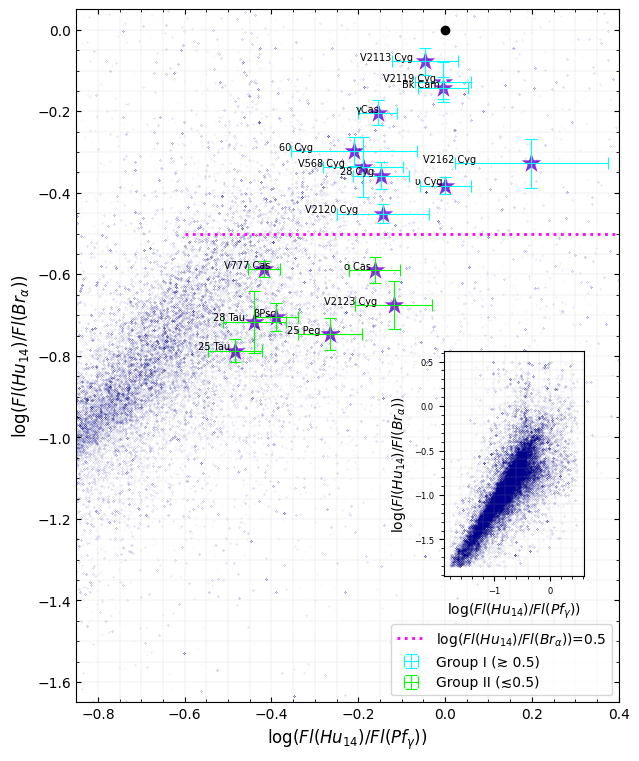

In [ ]:
# Cargar los datos
df = pd.read_csv('/content/drive/MyDrive/Be-HDUST/CornersPaper/extracted_data.csv', sep=',')

# Crear la figura y los subplots
fig, ax_scatter = plt.subplots(figsize=(7, 9))


# Definir las variables X y Y a partir de las columnas del DataFrame
X = data.iloc[:, 5]
y = data.iloc[:, 6]

# Crear el diagrama de dispersión con barras de error
sns.scatterplot(x='Hu14/F_lp_fγ_aprox', y='Hu14/Brα', data=df, s=400, marker='*', color='blueviolet', ax=ax_scatter)

# Inicializar variables para controlar la adición de las etiquetas del grupo
label_group_i_added = False
label_group_ii_added = False

# Agregar barras de error con colores específicos
for i, row in df.iterrows():
    if row['Estrella'] in ['V2113 Cyg', 'V2119 Cyg', 'V2120 Cyg', 'V2162 Cyg', 'Bk Cam', 'γCas', '28 Cyg', '60 Cyg', 'υ Cyg', 'ϕPer', 'V568 Cyg']:
        if not label_group_i_added:
            ax_scatter.errorbar(x=row['Hu14/F_lp_fγ_aprox'], y=row['Hu14/Brα'],
                                xerr=row['Error_LogHu14/F_lp_fγ_aprox'], yerr=row['Error_LogHu14/Brα'],
                                fmt='none', ecolor='cyan', capsize=4, capthick=0.8, elinewidth=0.8, label='Group I (≳ 0.5)')
            label_group_i_added = True
        else:
            ax_scatter.errorbar(x=row['Hu14/F_lp_fγ_aprox'], y=row['Hu14/Brα'],
                                xerr=row['Error_LogHu14/F_lp_fγ_aprox'], yerr=row['Error_LogHu14/Brα'],
                                fmt='none', ecolor='cyan', capsize=4, capthick=0.8, elinewidth=0.8)
    else:
        if not label_group_ii_added:
            ax_scatter.errorbar(x=row['Hu14/F_lp_fγ_aprox'], y=row['Hu14/Brα'],
                                xerr=row['Error_LogHu14/F_lp_fγ_aprox'], yerr=row['Error_LogHu14/Brα'],
                                fmt='none', ecolor='lime', capsize=4, capthick=0.8, elinewidth=0.8, label='Group II (≲0.5)')
            label_group_ii_added = True
        else:
            ax_scatter.errorbar(x=row['Hu14/F_lp_fγ_aprox'], y=row['Hu14/Brα'],
                                xerr=row['Error_LogHu14/F_lp_fγ_aprox'], yerr=row['Error_LogHu14/Brα'],
                                fmt='none', ecolor='lime', capsize=4, capthick=0.8, elinewidth=0.8)

# Agregar etiquetas de las estrellas
for i, row in df.iterrows():
    ax_scatter.text(row['Hu14/F_lp_fγ_aprox'] - row['Error_LogHu14/F_lp_fγ_aprox'] + 0.05,
                    row['Hu14/Brα'] + 0.002,
                    row['Estrella'],
                    fontsize=7, ha='right')

# Agregar un punto negro en (0, 0)
ax_scatter.scatter(0, 0, color='black', zorder=5)
ax_scatter.scatter(X, y, color='darkblue', marker='o', s=0.01, alpha=0.2)  # Puntos de dispersión

# Agregar una línea horizontal punteada desde -0.6 hasta -0.4 (clasificación de Mennickent)
ax_scatter.hlines(y=-0.5, xmin=-0.6, xmax=0.4, colors='magenta', linestyles='dotted', linewidth=2, label=r'$\log(Fl(Hu_{14})/Fl(Br_{\alpha}))$=0.5')

# Etiquetas y título con formato LaTeX
ax_scatter.set_xlabel(r'$\log(Fl(Hu_{14})/Fl(Pf_{\gamma}))$', fontsize=12)
ax_scatter.set_ylabel(r'$\log(Fl(Hu_{14})/Fl(Br_{\alpha}))$', fontsize=12)
ax_scatter.set_xlim(-0.85, 0.4)
ax_scatter.set_ylim(-1.65, 0.05)

# Activar marcas menores
ax_scatter.minorticks_on()
ax_scatter.grid(which='both', linestyle=':', linewidth=0.3)
ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# Crear un subplot en la parte inferior derecha
left, bottom, width, height = [0.65, 0.25, 0.2, 0.25]
ax_inset = fig.add_axes([left, bottom, width, height])

# Gráfico de dispersión en el subplot
ax_inset.scatter(X, y, color='darkblue', marker='o', s=0.01, alpha=0.2)

# Configurar etiquetas de los ejes del subplot
ax_inset.set_xlabel(r'$\log(Fl(Hu_{14})/Fl(Pf_{\gamma}))$', fontsize=10)
ax_inset.set_ylabel(r'$\log(Fl(Hu_{14})/Fl(Br_{\alpha}))$', fontsize=10
)
ax_inset.tick_params(axis='both', which='major', labelsize=6)
ax_inset.minorticks_on()
ax_inset.grid(which='both', linestyle=':', linewidth=0.3)

# Ajustar el layout
#plt.tight_layout()
ax_scatter.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/Be-HDUST/CornersPaper/Lenorzer_models_diagram.png', dpi=720)

# Mostrar el gráfico
plt.show()


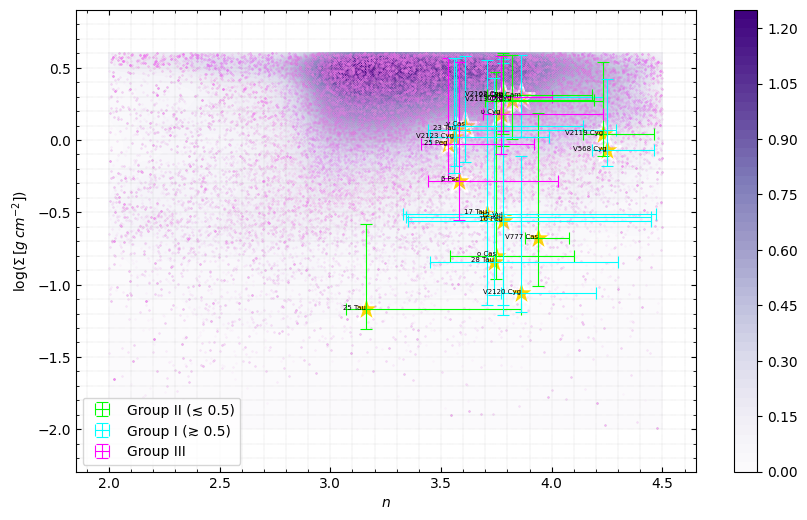

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Diccionario data2
data2 = {
    "Object": ["o Cas", "γ Cas", "V777 Cas", "Bk Cam", "17 Tau", "23 Tau","25 Tau", "28 Tau", "12 Vul", "28 Cyg", "V2113 Cyg", "V2119 Cyg",
            "V2120 Cyg", "β Psc", "25 Peg", "16 Peg", "V2162 Cyg", "υ Cyg","60 Cyg", "V568 Cyg", "V2123 Cyg"],
    "Group": ["II", "I", "II", "I", "I", "I","II", "I", "I", "III", "II", "II", "I", "III", "III", "I", "II", "III",
              "II", "I", "I"],
    "n": [3.75, 3.61, 3.94, 3.86, 3.71, 3.57,
          3.16, 3.74, 3.78, 3.78, 3.78, 4.23,
          3.86, 3.58, 3.53, 3.78, 3.78, 3.77,
          3.82, 4.25, 3.56],
    "n_err_low": [0.21, 0.08, 0.06, 0.07, 0.38, 0.13,
                  0.09, 0.29, 0.44, 0.05, 0.08, 0.09,
                  0.09, 0.14, 0.12, 0.43, 0.07, 0.08,
                  0.07, 0.07, 0.11],
    "n_err_high": [0.35, 0.53, 0.14, 0.37, 0.76, 0.72,
                  0.70, 0.56, 0.67, 0.22, 0.45, 0.23,
                  0.34, 0.45, 0.39, 0.67, 0.40, 0.46,
                  0.37, 0.21, 0.43],
    "logΣ": [-0.80, 0.10, -0.68, 0.30, -0.51, 0.07,
            -1.17, -0.84, -0.53, 0.30, 0.27, 0.04,
            -1.06, -0.28, -0.03, -0.56, 0.31, 0.18,
            0.28, -0.07, 0.02],
    "logΣ_err_low": [0.16, 0.25, 0.33, 0.28, 0.63, 0.25,
                    0.14, 0.23, 0.61, 0.24, 0.31, 0.15,
                    0.13, 0.27, 0.23, 0.65, 0.27, 0.28,
                    0.27, 0.11, 0.25],
    "logΣ_err_high": [1.27, 0.48, 0.87, 0.29, 1.06, 0.50,
                      0.59, 1.27, 1.09, 0.29, 0.33, 0.50,
                      0.95, 0.82, 0.60, 1.09, 0.28, 0.40,
                      0.31, 0.49, 0.55]
}

# Crear un DataFrame
df2 = pd.DataFrame(data2)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Inicializar variables para controlar la adición de las etiquetas del grupo
label_group_i_added = False
label_group_ii_added = False
label_group_iii_added = False

# Agregar barras de error con colores específicos
for i, row in df2.iterrows():
    if row['Group'] == 'I':
        color = 'cyan'
        if not label_group_i_added:
            ax.errorbar(x=row['n'], y=row['logΣ'],
                        xerr=[[row['n_err_low']], [row['n_err_high']]],
                        yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                        fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8, label='Group I (≳ 0.5)')
            label_group_i_added = True
        else:
            ax.errorbar(x=row['n'], y=row['logΣ'],
                        xerr=[[row['n_err_low']], [row['n_err_high']]],
                        yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                        fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8)
    elif row['Group'] == 'II':
        color = 'lime'
        if not label_group_ii_added:
            ax.errorbar(x=row['n'], y=row['logΣ'],
                        xerr=[[row['n_err_low']], [row['n_err_high']]],
                        yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                        fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8, label='Group II (≲ 0.5)')
            label_group_ii_added = True
        else:
            ax.errorbar(x=row['n'], y=row['logΣ'],
                        xerr=[[row['n_err_low']], [row['n_err_high']]],
                        yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                        fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8)
    elif row['Group'] == 'III':
        color = 'magenta'
        if not label_group_iii_added:
            ax.errorbar(x=row['n'], y=row['logΣ'],
                        xerr=[[row['n_err_low']], [row['n_err_high']]],
                        yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                        fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8, label='Group III')
            label_group_iii_added = True
        else:
            ax.errorbar(x=row['n'], y=row['logΣ'],
                        xerr=[[row['n_err_low']], [row['n_err_high']]],
                        yerr=[[row['logΣ_err_low']], [row['logΣ_err_high']]],
                        fmt='none', ecolor=color, capsize=4, capthick=0.8, elinewidth=0.8)

# Añadir etiquetas para cada punto
for i, row in df2.iterrows():
    ax.text(row['n'], row['logΣ'], row['Object'], fontsize=5, ha='right')

lenorzer_data = pd.read_csv('/content/drive/MyDrive/Be-HDUST/CornersPaper/samples_lenorzer.out', sep=' ', names=column_names)
# Definir las variables X y Y a partir de las columnas del DataFrame
X = lenorzer_data.iloc[:,0]
y = lenorzer_data.iloc[:,1]



# Crear un grid para los contornos
x_grid = np.linspace(X.min(), X.max(), 50)
y_grid = np.linspace(y.min(), y.max(), 50)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Calcular la densidad con una función de densidad de kernel (KDE)
kde = gaussian_kde(np.vstack([X, y]))
Z = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)

# Dibujar las superficies de nivel
contour = ax.contourf(X_grid, Y_grid, Z, levels=50, cmap="Purples")



# Agregar una barra de color
cbar = plt.colorbar(contour, ax=ax)



# Crear el diagrama de dispersión con Seaborn
sns.scatterplot(x='n', y='logΣ', data=df2, s=400, marker='*', color='gold', ax=ax)
ax.scatter(X, y, color='violet', marker='o', s=0.05, alpha=0.2)  # Puntos de dispersión
# Etiquetas de los ejes
ax.set_xlabel(r'$n$', fontsize=10)
ax.set_ylabel(r'$\log(\Sigma \, [g \, cm^{-2}])$', fontsize=10)

# Etiquetas y título con formato LaTeX
ax.set_xlim(np.min(data.iloc[:, 0])-0.15, np.max(data.iloc[:, 0])+0.15)
ax.set_ylim(np.min(data.iloc[:, 1])-0.3, np.max(data.iloc[:, 1])+0.3)

# Activar marcas menores
ax.minorticks_on()
ax.grid(which='both', linestyle=':', linewidth=0.3)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# Mostrar la leyenda
ax.legend()

# Mostrar la gráfica
plt.show()
